In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
listings = pd.read_csv("data" + os.sep + "listings.csv")
listings_detail = pd.read_csv("data" + os.sep + "listings_detail.csv")

/home/yangsi/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (43,61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
reviews = pd.read_csv("data" + os.sep + "reviews.csv")
reviews_detail = pd.read_csv("data" + os.sep + "reviews_detail.csv")

#### 分析房屋供给者基本情况

In [4]:
# listings_detail中关于房东的信息特征
host_col = ['host_id', 'host_url', 'host_name', 
            'host_since',
            'host_location',        # 先不考虑，太过杂乱 
            'host_about',           # 是否为null ？ -- 中英文? -- 字数？ 
            'host_response_time', 
            'host_response_rate', 
#             'host_acceptance_rate',
            'host_is_superhost',
            'host_thumbnail_url',
            'host_picture_url',
            'host_neighbourhood',    # 通常为比较知名的地点，如何使用
            'host_listings_count',   # 与host_total_listings_count相同, 含义未知
            'host_total_listings_count',
            'host_verifications',    # 一系列房东的确认方式 
            'host_has_profile_pic',  # 为 False 只有16个 
            'host_identity_verified',
            # 房东发布的所有房源数量， 即整栋房子 + 单独房间 + 共享房间
            'calculated_host_listings_count',
            'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms']

In [5]:
listings_detail["host_since"] = listings_detail["host_since"].map(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d"))
listings_detail["host_since_year"] = listings_detail["host_since"].map(lambda d: d.year)
listings_detail["host_since_month"] = listings_detail["host_since"].map(lambda d: d.month)

In [6]:
host_col += ["host_since_year", 'host_since_month']

In [7]:
host_df = listings_detail[host_col].drop_duplicates(subset="host_id", keep="first")

In [8]:
host_count_df = host_df.rename(columns = {"host_since_year": "year"}).groupby(["year"])["host_id"].count()
host_count_df = pd.DataFrame(host_count_df)
host_count_df.columns = ["increase_amount"]

In [9]:
host_count_df["cum_amount"] = host_count_df["increase_amount"].cumsum()

In [10]:
host_count_df["cum_shift"] = host_count_df["cum_amount"].shift(1)
host_count_df["increase_percent"] = host_count_df.apply(lambda r: r["increase_amount"]/r["cum_shift"], axis = 1)
host_count_df = host_count_df.drop(columns = ["cum_shift"])
host_count_df

increase_amount  cum_amount  increase_percent
year                                               
2010                3           3               NaN
2011               14          17          4.666667
2012               37          54          2.176471
2013              128         182          2.370370
2014              493         675          2.708791
2015             1164        1839          1.724444
2016             2136        3975          1.161501
2017             2337        6312          0.587925
2018             3365        9677          0.533112
2019             1115       10792          0.115222

In [12]:
save_file = "result" + os.sep + "host_increase.xlsx"
host_count_df.stack().unstack(["year"])\
             .rename(columns = {"increase_amount":"新增房东数量", 
                              "cum_amount":"累积房东数量",
                              "increase_percent": "新增房东速率"})#.to_excel(save_file)

year              2010       2011       2012       2013        2014  \
increase_amount    3.0  14.000000  37.000000  128.00000  493.000000   
cum_amount         3.0  17.000000  54.000000  182.00000  675.000000   
increase_percent   NaN   4.666667   2.176471    2.37037    2.708791   

year                     2015         2016         2017         2018  \
increase_amount   1164.000000  2136.000000  2337.000000  3365.000000   
cum_amount        1839.000000  3975.000000  6312.000000  9677.000000   
increase_percent     1.724444     1.161501     0.587925     0.533112   

year                      2019  
increase_amount    1115.000000  
cum_amount        10792.000000  
increase_percent      0.115222

In [72]:
print(host_count_df.stack().unstack(["year"])\
             .rename(columns = {"increase_amount":"新增房东数量", 
                              "cum_amount":"累积房东数量",
                              "increase_percent": "新增房东速率"}).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
year &  2010 &       2011 &       2012 &       2013 &        2014 &         2015 &         2016 &         2017 &         2018 &          2019 \\
\midrule
increase\_amount  &   3.0 &  14.000000 &  37.000000 &  128.00000 &  493.000000 &  1164.000000 &  2136.000000 &  2337.000000 &  3365.000000 &   1115.000000 \\
cum\_amount       &   3.0 &  17.000000 &  54.000000 &  182.00000 &  675.000000 &  1839.000000 &  3975.000000 &  6312.000000 &  9677.000000 &  10792.000000 \\
increase\_percent &   NaN &   4.666667 &   2.176471 &    2.37037 &    2.708791 &     1.724444 &     1.161501 &     0.587925 &     0.533112 &      0.115222 \\
\bottomrule
\end{tabular}



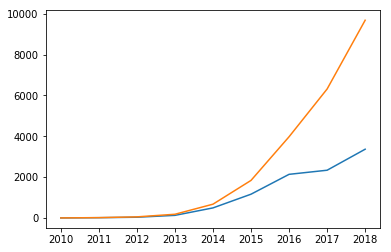

In [15]:
plt.plot(host_count_df["increase_amount"][:-1])
plt.plot(host_count_df["cum_amount"][:-1])

In [13]:
host_df["host_response_time"] = host_df["host_response_time"].fillna("no detected")

In [16]:
save_file = "result" + os.sep + "host_acivity.xlsx"
tmp_df = host_df.groupby(["host_since_year"])["host_response_time"].value_counts().unstack()
tmp_df.div(tmp_df.sum( axis = 1 ), axis = 0).to_excel(save_file)

#### 分析房屋数量

In [17]:
listings_count_df = listings_detail \
                    .rename(columns = {"host_since_year": "year"}) \
                    .groupby(["year"])["id"].count()
listings_count_df = pd.DataFrame(listings_count_df)
listings_count_df.columns = ["increase_amount"]
listings_count_df["cum_amount"] = listings_count_df["increase_amount"].cumsum()
listings_count_df["sum_shift"] = listings_count_df["cum_amount"].shift(1)
listings_count_df["increase_percent"] = listings_count_df.apply(lambda r : r["increase_amount"]/r["sum_shift"], axis =1)
listings_count_df

increase_amount  cum_amount  sum_shift  increase_percent
year                                                          
2010               11          11        NaN               NaN
2011               36          47       11.0          3.272727
2012               64         111       47.0          1.361702
2013              285         396      111.0          2.567568
2014             1196        1592      396.0          3.020202
2015             2760        4352     1592.0          1.733668
2016             4951        9303     4352.0          1.137638
2017             6841       16144     9303.0          0.735354
2018             9680       25824    16144.0          0.599604
2019             2628       28452    25824.0          0.101766

In [19]:
save_file = "result" + os.sep + "listings_amount.xlsx"
listings_count_df.stack().unstack(["year"]).to_excel(save_file)

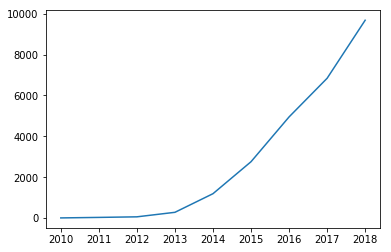

In [20]:
plt.plot(listings_count_df["increase_amount"][:-1])

#### 从 reviews 以及 reviews detail 中来观察房屋需求房的增长趋势
#### 该趋势并不准确， 仅是评价者

In [35]:
reviews_detail["date"] = reviews_detail["date"].map(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d"))
reviews_detail["year"] = reviews_detail["date"].map(lambda d: d.year)
reviews_detail["month"] = reviews_detail["date"].map(lambda d: d.month)
reviews_detail.head(5)

listing_id       id       date  reviewer_id reviewer_name  \
0       44054    84748 2010-08-25       207019        Jarrod   
1       44054   118384 2010-10-13       218723      Kimberly   
2       44054   436978 2011-08-11       609177          Emma   
3       44054  1118657 2012-04-12      1787536      Andreyna   
4       44054  2140650 2012-08-30      1179565       Frances   

                                            comments  year  month  
0  Sev was very helpful.  Sev showed us where to ...  2010      8  
1  We arrived in Beijing very early in the mornin...  2010     10  
2  It is a really massive apartment and really co...  2011      8  
3  Sev was incredibly helpful, showed us around t...  2012      4  
4  The appartment was ideal for our party of 6 ad...  2012      8

In [36]:
review_count_df = reviews_detail["reviewer_id"].value_counts()
review_count_df = pd.DataFrame(review_count_df)
review_count_df.columns = ["count"]
review_count_df["reviewer_id"] = review_count_df.index
review_count_df = review_count_df.reset_index(drop  = True)

In [37]:
reviews_detail = pd.merge(reviews_detail, review_count_df, on = ["reviewer_id"])

In [38]:
# 计算每年新增该地区活跃用户 -- 即该用户在该地区首次评论
# 只处理有多次评价的用户，大大减少时间

def cal_time_feat(group):
    group = group.sort_values(by = ["date"])
    group["first_date"] = group["date"].values[0]
    group["last_review"] = group["date"].shift(1)
    return group

reviews_detail_1 = reviews_detail[reviews_detail["count"]>1] \
                .groupby(["reviewer_id"]).apply(cal_time_feat)

In [39]:
reviews_detail_0 = reviews_detail[reviews_detail["count"] == 1]
reviews_detail_0.loc[:, "first_date"] = reviews_detail_0["date"]
reviews_detail_0.loc[:, "last_review"] = np.nan

In [40]:
reviews_detail = pd.concat([reviews_detail_0, reviews_detail_1])

In [41]:
reviews_detail.groupby(["year"])["id"].count()

year
2010        2
2011       24
2012      123
2013      306
2014      624
2015     2551
2016    12042
2017    38593
2018    95899
2019    51935
Name: id, dtype: int64

In [42]:
reviews_detail["first_year"] = reviews_detail["first_date"].map(lambda d: d.year)

In [45]:
count_df = reviews_detail.groupby(["first_year", "year"])["id"].count().unstack()

In [46]:
count_df

year        2010  2011   2012   2013   2014    2015     2016     2017  \
first_year                                                              
2010         2.0   NaN    NaN    NaN    NaN     NaN      NaN      NaN   
2011         NaN  24.0    NaN    NaN    NaN     NaN      NaN      1.0   
2012         NaN   NaN  123.0    NaN    NaN     2.0      2.0      NaN   
2013         NaN   NaN    NaN  306.0    6.0     5.0      3.0      2.0   
2014         NaN   NaN    NaN    NaN  618.0    16.0     18.0     10.0   
2015         NaN   NaN    NaN    NaN    NaN  2528.0    100.0     87.0   
2016         NaN   NaN    NaN    NaN    NaN     NaN  11919.0    701.0   
2017         NaN   NaN    NaN    NaN    NaN     NaN      NaN  37792.0   
2018         NaN   NaN    NaN    NaN    NaN     NaN      NaN      NaN   
2019         NaN   NaN    NaN    NaN    NaN     NaN      NaN      NaN   

year           2018     2019  
first_year                    
2010            NaN      NaN  
2011            NaN      NaN  
2012            NaN      1.0  
2013            4.0      NaN  
2014           11.0      2.0  
2015          116.0     40.0  
2016          523.0    156.0  
2017         2894.0    794.0  
2018        92351.0   4475.0  
2019            NaN  46467.0

In [44]:
save_file = "result" + os.sep + "reviewer.xlsx"
reviews_detail.groupby(["first_year", "year"])["id"].count().unstack().to_excel(save_file)

In [50]:
c = count_df.values
count_df["first_v"] = [c[x][np.where(~np.isnan(c[x]))][0] for x in range(len(count_df))]
count_df

year        2010  2011   2012   2013   2014    2015     2016     2017  \
first_year                                                              
2010         2.0   NaN    NaN    NaN    NaN     NaN      NaN      NaN   
2011         NaN  24.0    NaN    NaN    NaN     NaN      NaN      1.0   
2012         NaN   NaN  123.0    NaN    NaN     2.0      2.0      NaN   
2013         NaN   NaN    NaN  306.0    6.0     5.0      3.0      2.0   
2014         NaN   NaN    NaN    NaN  618.0    16.0     18.0     10.0   
2015         NaN   NaN    NaN    NaN    NaN  2528.0    100.0     87.0   
2016         NaN   NaN    NaN    NaN    NaN     NaN  11919.0    701.0   
2017         NaN   NaN    NaN    NaN    NaN     NaN      NaN  37792.0   
2018         NaN   NaN    NaN    NaN    NaN     NaN      NaN      NaN   
2019         NaN   NaN    NaN    NaN    NaN     NaN      NaN      NaN   

year           2018     2019  first_v  
first_year                             
2010            NaN      NaN      2.0  
2011            NaN      NaN     24.0  
2012            NaN      1.0    123.0  
2013            4.0      NaN    306.0  
2014           11.0      2.0    618.0  
2015          116.0     40.0   2528.0  
2016          523.0    156.0  11919.0  
2017         2894.0    794.0  37792.0  
2018        92351.0   4475.0  92351.0  
2019            NaN  46467.0  46467.0

In [55]:
save_file = "result" + os.sep + "review_percent.xlsx"
count_df.div(count_df["first_v"], axis = 0).drop(columns=["first_v"]).to_excel(save_file)

In [96]:
listings_price = listings[["id", "price"]]
listings_price = listings_price.rename(columns = {"id": "listing_id"})
listings_price.head(5)

listing_id  price
0       44054    792
1      100213   1201
2      128496    389
3      161902    376
4      162144    537

In [91]:
reviews_detail[reviews_detail["listing_id"] == 44054].shape

(89, 12)

In [97]:
reviews_detail = pd.merge(reviews_detail, listings_price, on = ["listing_id"])

In [103]:
profit_df = reviews_detail.groupby(["year"])["price"].sum()
profit_df = pd.DataFrame(profit_df)
profit_df.columns = ["profit"]
profit_df

profit
year          
2010      1584
2011      9862
2012     58418
2013    173316
2014    294357
2015   1068880
2016   5471024
2017  17630811
2018  41561903
2019  22780556

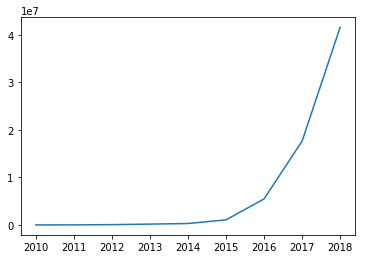

In [105]:
plt.plot(profit_df["profit"][:-1])

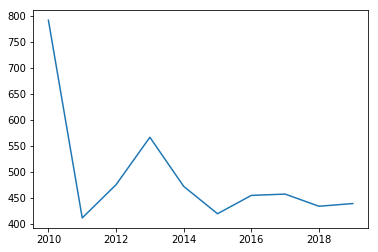

In [108]:
avg_price_df = reviews_detail.groupby(["year"])["price"].mean()
avg_price_df = pd.DataFrame(avg_price_df)
avg_price_df.columns = ["avg_price"]
plt.plot(avg_price_df["avg_price"])

In [109]:
avg_price_df

avg_price
year            
2010  792.000000
2011  410.916667
2012  474.943089
2013  566.392157
2014  471.725962
2015  419.004312
2016  454.328517
2017  456.839608
2018  433.392455
2019  438.635910

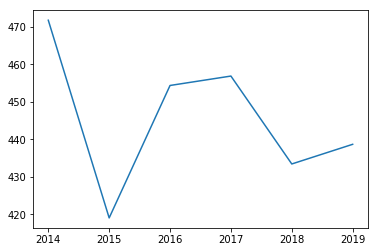

In [110]:
plt.plot(avg_price_df['avg_price'][4:])